In [250]:
#basics
import pandas as pd 
import numpy as np

#text manipulation
import re 
import string 

#files
import glob
import csv
import pickle

#nlp
import nltk
from nltk.tokenize import word_tokenize 
nltk.download('words')

#viz
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#sklearn
from sklearn.feature_extraction.text import CountVectorizer

# Wordcloud

## Define stopwords

In [272]:
# set stopwords equal to all english words
stopwords = nltk.corpus.words.words()
len(stopwords)

# iteratively create list of additional stopwords not caught by nltk english words
custom_stopwords = []
with open('app_stopwords.csv', newline='') as inputfile:
    for row in csv.reader(inputfile):
        custom_stopwords.append(row[0])


#add additional stopwords to list
for i in custom_stopwords:
    stopwords.append(i)
len(stopwords)

237722

## Load and preprocess text

In [268]:
df = pickle.load(open("document_df_clean.pickle", "rb"))
df.head()

,link_id,subreddit,body,doc_length,spacy_pipe
0,t3_8z5ew2,goldenretrievers,What's the new pupper's name? Utah,6,what the new pupper 's name
1,t3_8zrnvs,pitbulls,"Dude, she's beautiful!",3,pron beautiful
2,t3_90swcq,germanshepherds,Wow. I would make that into a tattoo ����,9,wow pron would make that a tattoo
3,t3_9230g8,germanshepherds,A big puppy hah,4,a big puppy hah
4,t3_925zut,pitbulls,Fair enough. Perish Sorry thought you someone ...,12,fair enough think pron someone else o angry


## Create wordcloud

In [269]:
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator

In [270]:
text1 = " ".join(review for review in df['spacy_pipe'])

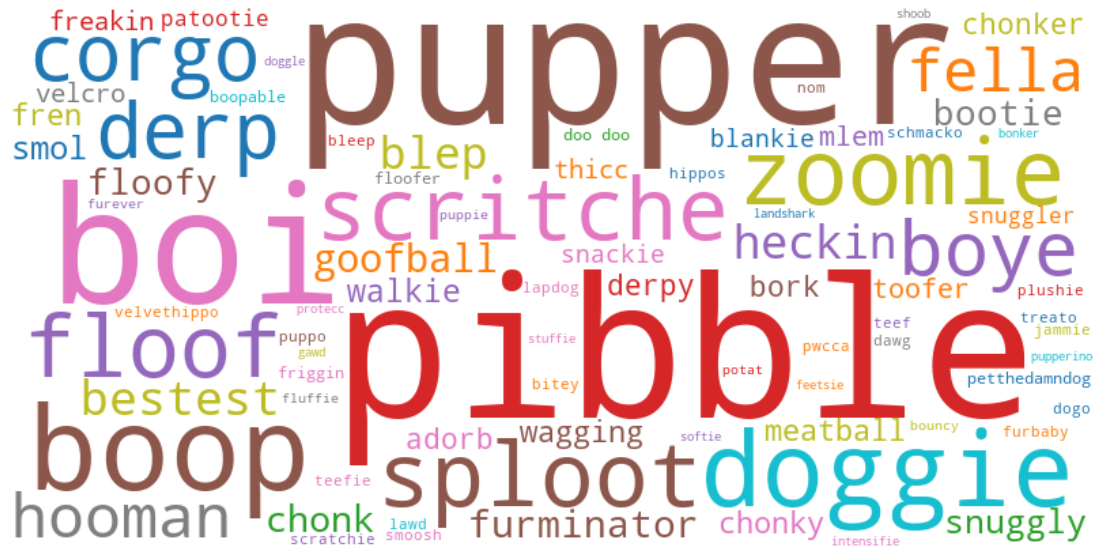

In [273]:
# Generate a word cloud image
wordcloud = WordCloud(width=800,
                      height=400, 
                      stopwords=stopwords,
                      background_color='white',
                      min_word_length=3,
                      colormap='tab10',
                      min_font_size=9,
                      random_state=0,
                      collocations=True,
                      collocation_threshold=10,
                      #max_font_size=8,
                      prefer_horizontal=1).generate(text1)

# Display the generated image:
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Prep data for streamlit app

## import reddit post (image) data

In [276]:
path = '/Users/labbot/Documents/metis_bootcamp/project04/allbreeds_posts_data/'
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    one_df = pd.read_csv(filename, index_col=None, header=0)
    li.append(one_df)

df_posts = pd.concat(li, axis=0, ignore_index=True)
df_posts.shape

(54467, 33)

In [277]:
# remove post where author is deleted, since image is also deleted
df_posts = df_posts[df_posts['author'] != "[deleted]"]
df_posts.shape

(51278, 33)

In [278]:
# for V1 I just want something that works, and I think reddit-hosted images are my best bet
# how many are there?
df_posts['domain'].value_counts()

i.redd.it                           36958
v.redd.it                            4073
i.imgur.com                          2499
imgur.com                            2170
instagram.com                        1625
                                    ...  
kctv5.com                               1
housingdisrepair.com                    1
sausagedogcentral.com                   1
self.LifeProTips                        1
scontent-lga3-1.cdninstagram.com        1
Name: domain, Length: 236, dtype: int64

In [279]:
# looks like if I keep the i.redd.it and i.imgur (all direct image links), I'll have almost 40K images; seems ok
df_posts = df_posts[(df_posts['domain'] == 'i.redd.it') | (df_posts['domain'] == 'i.imgur.com')]

In [281]:
# drop columns I don't care about
df_posts.drop(columns=['gilded','stickied','retrieved_on','over_18','hide_score','link_flair_css_class','author_flair_css_class',
                      'archived','quarantine','link_flair_text','distinguished','name','author_flair_text','is_self'],inplace=True)
df_posts

,created_utc,subreddit,author,domain,url,num_comments,score,ups,downs,title,selftext,saved,id,from_kind,from,thumbnail,subreddit_id,from_id,permalink
6,1564878946,corgi,OURMOTTO,i.redd.it,https://i.redd.it/fmkiobssube31.jpg,1,1,NaN,NaN,Just some corgi cake,NaN,NaN,clq3dd,NaN,NaN,https://b.thumbs.redditmedia.com/NxqtSG8MbxPQk...,t5_2rdw8,NaN,/r/corgi/comments/clq3dd/just_some_corgi_cake/
7,1564880591,corgi,riiisa,i.redd.it,https://i.redd.it/o5d249twzbe31.jpg,16,120,NaN,NaN,I love corgis and made stickers ��,NaN,NaN,clqdet,NaN,NaN,default,t5_2rdw8,NaN,/r/corgi/comments/clqdet/i_love_corgis_and_mad...
9,1564881174,corgi,blondebomb30,i.redd.it,https://i.redd.it/ec4l7edn1ce31.jpg,1,78,NaN,NaN,Living her best life,NaN,NaN,clqgwe,NaN,NaN,https://b.thumbs.redditmedia.com/303ra3x24Rfmc...,t5_2rdw8,NaN,/r/corgi/comments/clqgwe/living_her_best_life/
10,1564881354,corgi,pyroz9,i.redd.it,https://i.redd.it/uskr2is42ce31.jpg,3,110,NaN,NaN,Rectangular sploot,NaN,NaN,clqhyk,NaN,NaN,https://b.thumbs.redditmedia.com/bK4kDuX55T2ar...,t5_2rdw8,NaN,/r/corgi/comments/clqhyk/rectangular_sploot/
11,1564881633,corgi,GodlessandLegless,i.imgur.com,https://i.imgur.com/W1ciXoL.jpg,2,45,NaN,NaN,In honor of her gotcha day,NaN,NaN,clqjmx,NaN,NaN,https://b.thumbs.redditmedia.com/4Pb_MSzycNfsJ...,t5_2rdw8,NaN,/r/corgi/comments/clqjmx/in_honor_of_her_gotch...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54453,1547050620,goldenretrievers,Imperiummaius,i.redd.it,https://i.redd.it/vy18c0a9af921.jpg,11,1266,NaN,NaN,What a gentleman!,NaN,NaN,ae8cma,NaN,NaN,https://b.thumbs.redditmedia.com/kPoThMg1liPzl...,t5_2st00,NaN,/r/goldenretrievers/comments/ae8cma/what_a_gen...
54454,1547055163,goldenretrievers,youngpremedandbroke,i.redd.it,https://i.redd.it/q88lz6ornf921.jpg,2,44,NaN,NaN,What I wish I was doing right now on this swel...,NaN,NaN,ae94mu,NaN,NaN,https://b.thumbs.redditmedia.com/Zg8L_0WsWpm6_...,t5_2st00,NaN,/r/goldenretrievers/comments/ae94mu/what_i_wis...
54455,1547060700,goldenretrievers,LastZoo,i.redd.it,https://i.redd.it/t6f3tde84g921.jpg,2,35,NaN,NaN,“Can you see me now?”,NaN,NaN,aea3dc,NaN,NaN,https://b.thumbs.redditmedia.com/YVyNc-NV0qvpL...,t5_2st00,NaN,/r/goldenretrievers/comments/aea3dc/can_you_se...
54457,1547067044,goldenretrievers,Nooreo__,i.redd.it,https://i.redd.it/8s0o9on2ng921.jpg,1,54,NaN,NaN,Odin at 8 weeks old. The man who steals my hea...,NaN,NaN,aeb6yw,NaN,NaN,https://b.thumbs.redditmedia.com/OIoz5-rdXSsQd...,t5_2st00,NaN,/r/goldenretrievers/comments/aeb6yw/odin_at_8_...


## merge post and comment data

In [282]:
#make ids match across tables
df_posts['link_id'] = 't3_' + df_posts['id']
df_posts.shape

(39457, 20)

In [283]:
# merge the comments data into the posts/images dataframe 
# keep only records that appear in both (we need an image AND comments)
df_posts = df_posts.merge(df,on='link_id',how='inner',suffixes=('None','_comments'))

In [287]:
df_posts.head(3) 

,created_utc,subredditNone,author,domain,url,num_comments,score,ups,downs,title,...,from,thumbnail,subreddit_id,from_id,permalink,link_id,subreddit_comments,body,doc_length,spacy_pipe
0,1564878946,corgi,OURMOTTO,i.redd.it,https://i.redd.it/fmkiobssube31.jpg,1,1,NaN,NaN,Just some corgi cake,...,NaN,https://b.thumbs.redditmedia.com/NxqtSG8MbxPQk...,t5_2rdw8,NaN,/r/corgi/comments/clq3dd/just_some_corgi_cake/,t3_clq3dd,corgi,God why,2,why
1,1564880591,corgi,riiisa,i.redd.it,https://i.redd.it/o5d249twzbe31.jpg,16,120,NaN,NaN,I love corgis and made stickers ��,...,NaN,default,t5_2rdw8,NaN,/r/corgi/comments/clqdet/i_love_corgis_and_mad...,t3_clqdet,corgi,Second I'm so glad! �� No UK orders ��\nAny ch...,150,second pron so glad no order any chanc...
2,1564881174,corgi,blondebomb30,i.redd.it,https://i.redd.it/ec4l7edn1ce31.jpg,1,78,NaN,NaN,Living her best life,...,NaN,https://b.thumbs.redditmedia.com/303ra3x24Rfmc...,t5_2rdw8,NaN,/r/corgi/comments/clqgwe/living_her_best_life/,t3_clqgwe,corgi,See Mom. It works. Just had to put the ears down.,11,see pron work just to put the ear


## remove stopwords from app dataset

In [274]:
# vectorize
corpus = df_posts['spacy_pipe']
vectorizer = CountVectorizer(stop_words=stopwords,min_df=10,ngram_range=(1, 2))
doc_word_matrix = vectorizer.fit_transform(corpus) 

/Users/labbot/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aani', 'aaron', 'aaronic', 'aaronical', 'aaronite', 'aaronitic', 'aaru', 'ab', 'ababdeh', 'ababua', 'abadite', 'abama', 'abanic', 'abantes', 'abarambo', 'abaris', 'abasgi', 'abassin', 'abatua', 'abba', 'abbadide', 'abbasside', 'abbie', 'abby', 'abderian', 'abderite', 'abdiel', 'abdominales', 'abe', 'abel', 'abelia', 'abelian', 'abelicea', 'abelmoschus', 'abelonian', 'abencerrages', 'aberdeen', 'aberdonian', 'aberia', 'abhorson', 'abie', 'abies', 'abietineae', 'abiezer', 'abipon', 'abitibi', 'abkhas', 'abkhasian', 'ablepharus', 'abnaki', 'abner', 'abo', 'abobra', 'abongo', 'abraham', 'abrahamic', 'abrahamidae', 'abrahamite', 'abrahamitic', 'abram', 'abramis', 'abranchiata', 'abrocoma', 'abroma', 'abronia', 'abrus', 'absalom', 'absaroka', 'absi', 'absyrtus', 'abundantia', 'abu

In [275]:
# get terms
terms = vectorizer.get_feature_names()

# save terms to pickle
with open('streamlit/dogterms.pickle', 'wb') as to_write:
    pickle.dump(terms, to_write)

## export final image dataframe

In [286]:
# create clean df of images and comments
df_streamlit = df_posts[['link_id','url','title','body','spacy_pipe','author']]
df_streamlit.columns = ['id','img_url','post_title','full_comments','clean_comments','author']

# save image-comment df to pickle
with open('streamlit/url_df.pickle', 'wb') as to_write:
    pickle.dump(df_streamlit, to_write)